ref: https://arxiv.org/pdf/2005.10036.pdf

1. run gin to get embedding
2. feed embedding to random forest / gp on train
3. apply on val and check MAE

In [1]:
import lightgbm

In [2]:
import torch
from torch_geometric.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR

from gnn import GNN

import os
from tqdm import tqdm
import argparse
import time
import numpy as np
import random

torch.cuda.is_available()

True

In [3]:
import os.path as osp
from ogb.lsc import PygPCQM4MDataset, PCQM4MEvaluator
import pickle

In [4]:
# get args from main_gnn CLI
class Argument(object):
    name = "args"
    
args = Argument()
args.batch_size = 256
args.num_workers = 0
args.num_layers = 5
args.emb_dim = 600
args.drop_ratio = 0
args.graph_pooling = "sum"
args.checkpoint_dir = "checkpoint"
args.device = 0

In [5]:
device = torch.device("cuda:" + str(args.device)) if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [6]:
shared_params = {
    'num_layers': args.num_layers,
    'emb_dim': args.emb_dim,
    'drop_ratio': args.drop_ratio,
    'graph_pooling': args.graph_pooling
}


## load model

In [7]:
modelName = "gin-virtual"
gnn_type = "gin"
virtual_node = True
    
"""
LOAD Checkpoint data
"""
filename = os.path.join(args.checkpoint_dir, "models", modelName, "checkpoint", 'checkpoint.pt')
checkpoint = torch.load(filename)

# load model
model = GNN(gnn_type = gnn_type, virtual_node = virtual_node, **shared_params).to(device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()    

GNN(
  (gnn_node): GNN_node_Virtualnode(
    (atom_encoder): AtomEncoder(
      (atom_embedding_list): ModuleList(
        (0): Embedding(119, 600)
        (1): Embedding(4, 600)
        (2): Embedding(12, 600)
        (3): Embedding(12, 600)
        (4): Embedding(10, 600)
        (5): Embedding(6, 600)
        (6): Embedding(6, 600)
        (7): Embedding(2, 600)
        (8): Embedding(2, 600)
      )
    )
    (virtualnode_embedding): Embedding(1, 600)
    (convs): ModuleList(
      (0): GINConv(
        (mlp): Sequential(
          (0): Linear(in_features=600, out_features=600, bias=True)
          (1): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Linear(in_features=600, out_features=600, bias=True)
        )
        (bond_encoder): BondEncoder(
          (bond_embedding_list): ModuleList(
            (0): Embedding(5, 600)
            (1): Embedding(6, 600)
            (2): Embedding(2, 600)
          )
     

## load data

In [8]:
import pandas as pd

In [9]:
### importing OGB-LSC
from ogb.lsc import PygPCQM4MDataset, PCQM4MEvaluator

dataset = PygPCQM4MDataset(root = 'dataset/')
split_idx = dataset.get_idx_split()

## test valid

In [ ]:
# """
# Get intermediate graph embeddings and visualise
# """
# def getPred(model):
#     valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=args.batch_size, shuffle=False, num_workers = args.num_workers)
    
#     y_pred = []
#     for step, batch in enumerate(tqdm(valid_loader, desc="Iteration")):

#         # put batch to cuda
#         batch = batch.to(device)

#         # collate prediction
#         with torch.no_grad():
#             pred = model(batch).view(-1,)    
#             pred_np = pred.detach().cpu().numpy()
#             y_pred.extend(pred_np)

#     return y_pred

In [23]:
# ## collate data as a list

# valid_data_list = []
# y_true = []
# for step, batch in enumerate(tqdm(valid_loader, desc="Iteration")):

#     # collate data
#     for i in range(batch.y.shape[0]):
#         valid_data_list.append(batch[i])

#     # collate label
#     label = batch.y.detach().cpu().numpy()
#     y_true.extend(label)

Iteration: 100%|███████████████████████████████████████████████████████████████████| 1487/1487 [00:58<00:00, 25.38it/s]


In [ ]:
# # get prediction
# y_pred = getPred(model)


In [25]:
# # evaluate
# evaluator = PCQM4MEvaluator()
# input_dict = {"y_true": torch.tensor(y_true), "y_pred": torch.tensor(y_pred)}
# evaluator.eval(input_dict)["mae"]

0.15115168690681458

## further train

In [11]:
train_loader = DataLoader(dataset[split_idx["train"]], batch_size=args.batch_size, shuffle=False, num_workers = args.num_workers)

In [15]:
def getGraphEmbedding(model, batch):
    with torch.no_grad():
        # get intermediate outputs
        h_node = model.gnn_node(batch)
        # GRAPH EMBEDDING
        h_graph = model.pool(h_node, batch.batch)
        # output
        output = model.graph_pred_linear(h_graph).view(-1)

    return h_graph, output

In [12]:
"""
Get intermediate graph embeddings and visualise
"""
# valid_data_list = []
for step, batch in enumerate(tqdm(train_loader, desc="Iteration")):

#     # collate data
#     for i in range(batch.y.shape[0]):
#         valid_data_list.append(batch[i])

    # put batch to cuda
    batch = batch.to(device)

    # get embedding
    h_graph, pred = getGraphEmbedding(model, batch)

    # collate prediction
    pred_np = pred.detach().cpu().numpy()
    filename = osp.join("checkpoint", "trainingEmbeddings", "preds", "{}.npy".format(step))
    np.save(filename, pred_np)

    # save graph embeddings
    h_graph_np = h_graph.detach().cpu().numpy()
    filename = osp.join("checkpoint", "trainingEmbeddings", "embeddings", "{}.npy".format(step))
    np.save(filename, h_graph_np)
    
    # save label
    label = batch.y.detach().cpu().numpy()
    filename = osp.join("checkpoint", "trainingEmbeddings", "labels", "{}.npy".format(step))
    np.save(filename, label)
    

Iteration: 100%|█████████████████████████████████████████████████████████████████| 11896/11896 [18:46<00:00, 10.56it/s]


In [ ]:
raise Exception("")

# shutdown the kernel, delete data

## evaluate training data

In [8]:
Ntrain = 11896

In [9]:
"""
load from storage
"""
y_true = []
y_pred = []

for step in tqdm(range(Ntrain)):
    filename = osp.join("checkpoint", "trainingEmbeddings", "preds", "{}.npy".format(step))
    pred_np = np.load(filename)
    y_pred.extend(pred_np)

#     filename = osp.join("checkpoint", "trainingEmbeddings", "embeddings", "{}.npy".format(step))
#     h_graph_np = np.load(filename)
#     graphEmbeddings.append(h_graph_np)
#     if graphEmbeddings is None:
#         graphEmbeddings = h_graph_np
#     else:
#         graphEmbeddings = np.concatenate((graphEmbeddings, h_graph_np))
    
    filename = osp.join("checkpoint", "trainingEmbeddings", "labels", "{}.npy".format(step))
    label = np.load(filename)
    y_true.extend(label)

100%|███████████████████████████████████████████████████████████████████████████| 11896/11896 [00:22<00:00, 525.36it/s]


In [10]:
Ndata = len(y_true)
dim = 600
graphEmbeddings = np.zeros((Ndata, dim))

In [11]:
# load separately as np.concatenate is too slow
for step in tqdm(range(Ntrain)):
    filename = osp.join("checkpoint", "trainingEmbeddings", "embeddings", "{}.npy".format(step))
    h_graph_np = np.load(filename)
    
    minVal = step*256
    maxVal = min((step+1)*256, Ndata)
    graphEmbeddings[minVal:maxVal, :] = h_graph_np

100%|███████████████████████████████████████████████████████████████████████████| 11896/11896 [00:49<00:00, 240.45it/s]


In [12]:
len(y_true), len(y_pred), graphEmbeddings.shape

(3045360, 3045360, (3045360, 600))

In [13]:
# evaluate
evaluator = PCQM4MEvaluator()
input_dict = {"y_true": torch.tensor(y_true), "y_pred": torch.tensor(y_pred)}
evaluator.eval(input_dict)["mae"]

0.10943220555782318

## run pca to reduce dimension of embeddings

In [13]:
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt

In [ ]:
# pca = PCA()
# pca.fit(graphEmbeddings)

# # see what's a good pca threshold
# plt.figure(figsize= (10, 5))
# plt.xticks(np.arange(0, graphEmbeddings.shape[1], step=10))
# plt.plot(pca.explained_variance_ratio_.cumsum())

## predict value

In [15]:
from lightgbm import LGBMRegressor

In [13]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.tree import DecisionTreeRegressor

In [27]:
# regr = RandomForestRegressor(max_depth=2, random_state=0, criterion="mae")
# regr = GradientBoostingRegressor(random_state=1, criterion="mae")
# regr = DecisionTreeRegressor(random_state=0)
# regr = DecisionTreeRegressor(random_state=0, criterion="mae")

regr = LGBMRegressor()

In [23]:
# random sampling
randomIndex = np.random.choice(Ndata, 50000, replace=False)

In [28]:
"""
TRAIN MODEL
"""

regr.fit(graphEmbeddings, y_true)
# regr.fit(graphEmbeddings[randomIndex], np.array(y_true)[randomIndex])

LGBMRegressor()

In [29]:
rfPred = regr.predict(graphEmbeddings)

In [30]:
input_dict = {"y_true": torch.tensor(y_true), "y_pred": torch.tensor(rfPred)}
evaluator.eval(input_dict)["mae"]

0.10800974458228811

In [39]:
# kernel = DotProduct() + WhiteKernel()
# gpr = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(graphEmbeddings, y_true)

In [40]:
# gprPred = gpr.predict(graphEmbeddings, return_std=False)

In [41]:
# input_dict = {"y_true": torch.tensor(y_true), "y_pred": torch.tensor(gprPred)}
# evaluator.eval(input_dict)["mae"]

In [31]:
import pickle

In [32]:
filename = osp.join("checkpoint", "trainingEmbeddings", "regr")
   
with open(filename, "wb") as f:
    pickle.dump(regr, f)

## evaluate the model on valid

1. extract valid embeddings
2. feed to regressor
3. test prediction

In [10]:
filename = osp.join("checkpoint", "trainingEmbeddings", "regr")
   
with open(filename, "rb") as f:
    regr = pickle.load(f)
    
regr

LGBMRegressor()

In [11]:
valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=args.batch_size, shuffle=False, num_workers = args.num_workers)

In [12]:
def getGraphEmbedding(model, batch):
    with torch.no_grad():
        # get intermediate outputs
        h_node = model.gnn_node(batch)
        # GRAPH EMBEDDING
        h_graph = model.pool(h_node, batch.batch)
        # output
        output = model.graph_pred_linear(h_graph).view(-1)

    return h_graph, output

In [13]:
"""
Get intermediate graph embeddings and visualise
"""
graphEmbeddingsList = []
y_true = []
y_pred = []
# valid_data_list = []
for step, batch in enumerate(tqdm(valid_loader, desc="Iteration")):

    # put batch to cuda
    batch = batch.to(device)

    # get embedding
    h_graph, pred = getGraphEmbedding(model, batch)

    # collate prediction
    pred_np = pred.detach().cpu().numpy()
    y_pred.extend(pred_np)

    # collate graph embedding
    h_graph_np = h_graph.detach().cpu().numpy()
    graphEmbeddingsList.append(h_graph_np)
#     if graphEmbeddings is None:
#         graphEmbeddings = h_graph_np
#     else:
#         graphEmbeddings = np.concatenate((graphEmbeddings, h_graph_np))

    # collate label
    label = batch.y.detach().cpu().numpy()
    y_true.extend(label)
    

Iteration: 100%|███████████████████████████████████████████████████████████████████| 1487/1487 [02:01<00:00, 12.27it/s]


In [14]:
Ndata = len(y_true)
dim = 600
graphEmbeddings = np.zeros((Ndata, dim))

In [15]:
Nval = 1487

In [16]:
# load separately as np.concatenate is too slow
for step in tqdm(range(Nval)):

    h_graph_np = graphEmbeddingsList[step]
    
    minVal = step*256
    maxVal = min((step+1)*256, Ndata)
    graphEmbeddings[minVal:maxVal, :] = h_graph_np

100%|████████████████████████████████████████████████████████████████████████████| 1487/1487 [00:00<00:00, 2394.51it/s]


In [17]:
rfPred = regr.predict(graphEmbeddings)

In [18]:
evaluator = PCQM4MEvaluator()


In [19]:
input_dict = {"y_true": torch.tensor(y_true), "y_pred": torch.tensor(y_pred)}
evaluator.eval(input_dict)["mae"]

0.15115167200565338

In [20]:
input_dict = {"y_true": torch.tensor(y_true), "y_pred": torch.tensor(rfPred)}
evaluator.eval(input_dict)["mae"]

0.1507685979572607

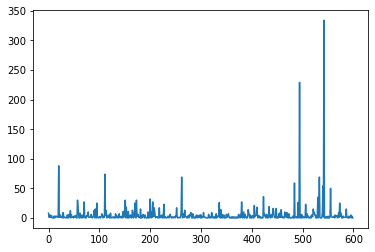

In [24]:
import matplotlib.pyplot as plt

plt.plot(regr.feature_importances_)